--------------------------

# Snapping point to segments

In [1]:
import os
if os.name == "posix":
    last_modified = !stat -f\
                    "# This notebook was last updated: %Sm"\
                     Snapping_Demonstration.ipynb # notebook file name
get_ipython().set_next_input(last_modified.s)

In [ ]:
# This notebook was last updated: Aug 19 20:22:49 2018

-------------------------------

In [2]:
import numpy as np
from libpysal import cg, examples, io
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

__author__ = "Serge Rey <sjsrey@gmail.com>, James Gaboardi <jgaboardi@gmail.com>"

In [3]:
def squaredDistance(point, segment):
    """Find the squared distance between a point and a segment
    
    Arguments
    =========
    point: tuple (x,y)
    segment: list of tuples [(x0,y0), (x1,y1)]
    Returns
    =======
    tuple: 2 elements
           distance squared between point and segment
           array(xb, yb): the nearest point on the segment
    """
    p0,p1 = [np.array(p) for p in segment]
    v = p1 - p0
    p = np.array(point)
    w = p - p0
    c1 = np.dot(w,v)
    if c1 <= 0.:
        return np.dot(w.T,w), p0
    c2 = np.dot(v,v)
    if c2 <= c1:
        dp1 = p - p1
        return np.dot(dp1.T,dp1), p1
    
    b = c1 / c2
    bv = np.dot(b,v)
    pb = p0 + bv
    d2 = p - pb
    
    return np.dot(d2,d2), pb

In [4]:
def snapPointsOnSegments(points, segments):
    """Place points onto closet segment in a set of segments
    
    Arguments
    =========
    points: dictionary of (id, (x,y))
    segments: sequence of pysal.cg.shapes.Chain
              Note that the each segment is a chain with
              *one head and one tail node*, in other words
              one link only.         
    Returns
    =======
    p2s: dictionary
         key: a point (see points in arguments)
         value:  a 2-tuple: ((head, tail), point)
                 where (head, tail) is the target segment,
                 and point is the snapped location on the segment     
    """
    # Put segments in an Rtree
    rt = cg.Rtree()
    SMALL = np.finfo(float).eps
    node2segs = {}
    
    for segment in segments:
        head,tail = segment.vertices
        x0,y0 = head
        x1,y1 = tail
        if (x0,y0) not in node2segs:
            node2segs[(x0,y0)] = []
        if (x1,y1) not in node2segs:
            node2segs[(x1,y1)] = []
        node2segs[(x0,y0)].append(segment)
        node2segs[(x1,y1)].append(segment)
        x0,y0,x1,y1 =  segment.bounding_box
        x0 -= SMALL
        y0 -= SMALL
        x1 += SMALL
        y1 += SMALL
        r = cg.Rect(x0,y0,x1,y1)
        rt.insert(segment, r)
    
    # Build a KDtree on segment nodes
    kt = cg.KDTree(list(node2segs.keys()))
    p2s = {}
    
    for ptIdx, point in points.items():
        # first find nearest neighbor segment node for point
        dmin, node = kt.query(point, k=1)
        node = tuple(kt.data[node])
        closest = node2segs[node][0].vertices
        
        # use this segment as the candidate closest segment: closest
        # use the distance as the distance to beat: dmin
        p2s[ptIdx] = (closest, node) # sna
        x0 = point[0] - dmin
        y0 = point[1] - dmin
        x1 = point[0] + dmin
        y1 = point[1] + dmin
        
        # find all segments with bounding boxes that intersect
        # a query rectangle centered on the point with sides of length 2*dmin
        candidates = [cand for cand in rt.intersection([x0,y0,x1,y1])]
        dmin += SMALL
        dmin2 = dmin * dmin
        
        # of the candidate segments, find the one that is the minimum distance to the query point
        for candidate in candidates:
            dnc, p2b = squaredDistance(point, candidate.vertices)
            if dnc <= dmin2:
                closest = candidate.vertices
                dmin2 = dnc
                p2s[ptIdx] = (closest, p2b)
        
    return p2s

-----------------------------------------

# Demonstration

## Segments

In [5]:
eb = io.FileIO.FileIO.open(examples.get_path("eberly_net.shp"))

#### Note that eberly has `chain == segment`, for all chains. This is not necessarily true for all chains in polyline shapefiles.

In [6]:
segments = [chain for chain in eb]
segments[:3]

## Points

In [7]:
ep = io.FileIO.FileIO.open(examples.get_path("eberly_net_pts_offnetwork.shp"))

In [8]:
points = {}
for i,pnt in enumerate(ep):
    points[i] = pnt
list(points.items())[:3]

[(0, (7.305940740259589, 5.343966284055054)),
 (1, (17.484772861944425, 1.3880022945802004)),
 (2, (8.031236399903136, 6.876326289957974))]

## Initial plot

((-1, 25), (-1, 10))

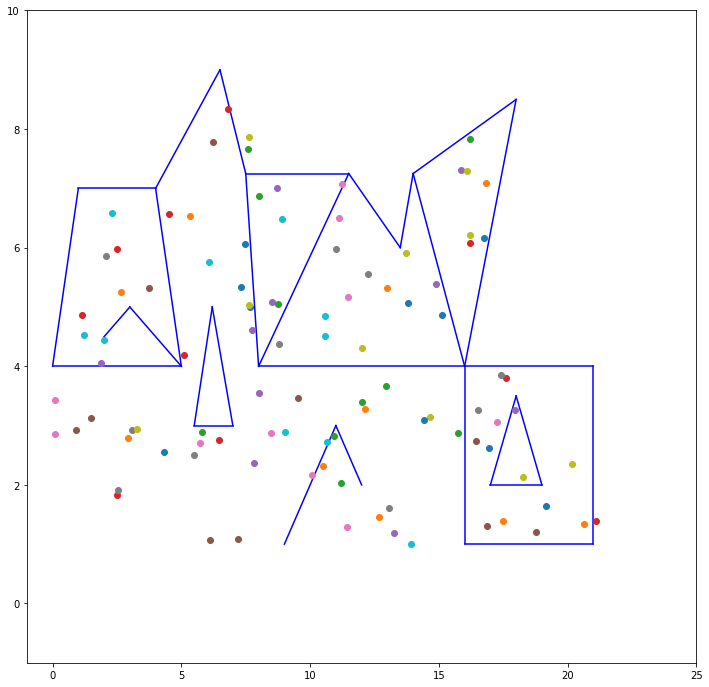

In [9]:
plt.figure(figsize=(12,12))
network = []
for segment in segments:
    head, tail = segment.vertices
    x1, y1 = head
    x2, y2 = tail
    network.append((x1, x2))
    network.append((y1, y2))
    network.append('b')
plt.plot(*network)
for i, point in points.items():
    x,y = point
    plt.plot(x, y, 'o')
plt.xlim(-1, 25), plt.ylim(-1, 10)

## Snap point onto nearest segments

In [10]:
res = snapPointsOnSegments(points, segments)

ZeroDivisionError: float division by zero

## Snapped points plot

In [ ]:
plt.figure(figsize=(12,12))
network = []
for segment in segments:
    head, tail = segment.vertices
    x1, y1 = head
    x2, y2 = tail
    network.append((x1, x2))
    network.append((y1, y2))
    network.append('b')
plt.plot(*network)
for i, point in points.items():
    snapped = res[i]
    x, y = snapped[1]
    plt.plot(x,y, 'o')
plt.xlim(-1,25), plt.ylim(-1,10)

---------------------------------------------